<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
       Intel Image Classification using PyTorch
    </h2>
</div>




### Project Overview

This notebook demonstrates a complete workflow for an image classification task using the **Intel Image Classification dataset**.

The workflow includes:
- Building a **CNN from scratch**
- Improving performance using **Data Augmentation**
- Optimizing hyperparameters using **Optuna**
- Visualizing results and optimization insights

The goal is not only high accuracy, but also **clear experimentation, reproducibility, and interpretability**.

---


### Dataset Description

The **Intel Image Classification dataset** contains natural scene images categorized into six classes:

| Class | Description |
|------|------------|
| Buildings | Urban and architectural scenes |
| Forest | Dense vegetation and trees |
| Glacier | Snow and ice landscapes |
| Mountain | Rocky and elevated terrains |
| Sea | Coastal and ocean scenes |
| Street | City streets and roads |

**Dataset Characteristics**
- Total images: ~25,000
- Image resolution: ~150 × 150
- Task type: Multi-class image classification
- Number of classes: 6
---


### PROBLEM STATEMENT

The task is to build an image classification model capable of correctly
identifying the scene category of a given image from six possible classes:
Buildings, Forest, Glacier, Mountain, Sea, and Street.

The primary challenge lies in achieving strong generalization across visually
diverse environments while avoiding overfitting to the training data.

---

### Objectives

- Establish a baseline using a convolutional neural network trained from scratch
- Analyze overfitting behavior through training and validation performance
- Apply hyperparameter optimization to improve model performance
- Introduce data augmentation to enhance generalization
- Leverage transfer learning with pretrained ImageNet models
- Compare different fine-tuning strategies to identify the optimal approach

Model performance is evaluated using classification accuracy, confusion
matrices, and qualitative analysis of predictions on a held-out test set.


<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Imports
    </h2>
</div>


In [ ]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
import math

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from collections import Counter
import optuna
import matplotlib.pyplot as plt
from optuna.visualization import matplotlib as optuna_plt

import warnings
from optuna.exceptions import ExperimentalWarning

warnings.filterwarnings(
    "ignore",
    category=ExperimentalWarning
)




SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Dataset Loading
    </h2>
</div>


In [118]:
DATA_DIR = '/kaggle/input/intel-image-classification/seg_train/seg_train'

basic_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(
    root = DATA_DIR,
    transform = basic_transform
)

In [119]:
class_names = dataset.classes
num_classes = len(class_names)

num_classes, class_names

(6, ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

In [120]:
targets = [label for _, label in dataset.samples]
class_counts = Counter(targets)

class_distribution = pd.DataFrame({
    'Class': class_names,
    'Image Count': [class_counts[i] for i in range(num_classes)]
})

class_distribution

Class  Image Count
0  buildings         2191
1     forest         2271
2    glacier         2404
3   mountain         2512
4        sea         2274
5     street         2382

### A Quick visual understanding

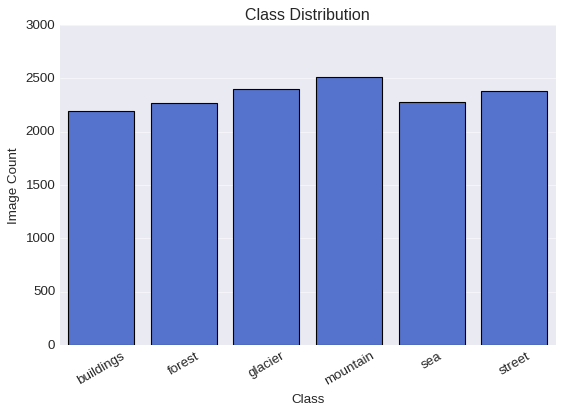

In [121]:
plt.figure(figsize = (8, 5))

sns.barplot(
    data = class_distribution,
    x = 'Class',
    y = 'Image Count',
    color = 'royalblue'
)

plt.title('Class Distribution')
plt.xticks(rotation = 30)
plt.show()

### Sample images are nearly equally distributed among the classes

In [122]:
def show_samples(dataset, class_names, samples_per_class=5):
    fig, axes = plt.subplots(len(class_names),
                             samples_per_class,
                             figsize=(15, 10),
                            facecolor = 'lightgrey')
    
    for class_idx, class_name in enumerate(class_names):
        class_images = [img for img, label in dataset if label == class_idx][:samples_per_class]
        
        for i in range(samples_per_class):
            ax = axes[class_idx, i]
            
            if i < len(class_images):
                img = class_images[i]

                ax.imshow(img.permute(1, 2, 0))
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            if i == 0:
                ax.set_ylabel(class_name,
                              rotation=0,
                              ha='right',
                              va='center',
                              labelpad=10)

            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color('white')
                spine.set_linewidth(2)
                
    fig.suptitle(
        'Sample Images from Each Class',
        fontsize = 16,
        fontweight = 'bold'
    )    
    plt.tight_layout(rect = [0, 0, 1, 0.95])
    plt.show()



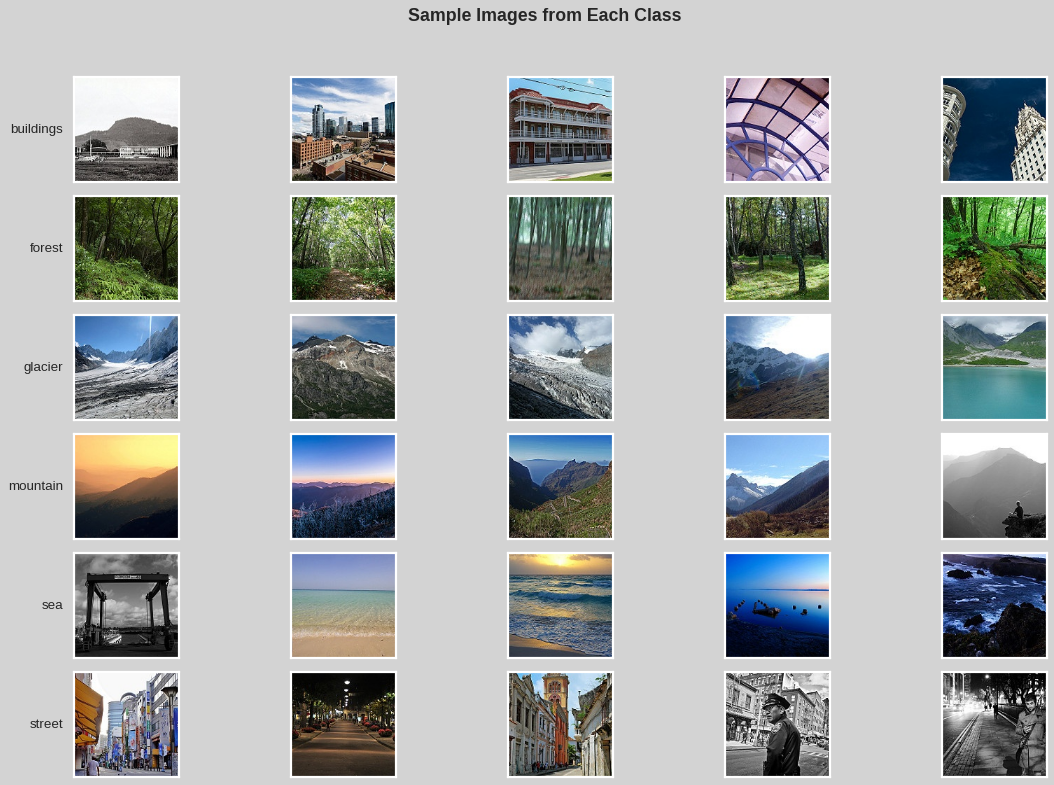

In [123]:
show_samples(dataset, class_names)

### Key Observations

- The dataset is reasonably balanced across classes
- Visual diversity exists within each category
- Image resolution is sufficient for CNN-based models
- The dataset is well-suited for:
  - Training CNNs from scratch
  - Applying transfer learning
  - Demonstrating the effect of data augmentation


<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Data Splitting
    </h2>
</div>


In [124]:
TRAIN_RATIO = 0.8

train_size = int(TRAIN_RATIO * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator = torch.Generator().manual_seed(SEED)
)

<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Baseline CNN: Model from Scratch
    </h2>
</div>


As a starting point, we design and train a convolutional neural network (CNN)
from scratch. This baseline model serves as a reference for understanding
learning behavior, overfitting tendencies, and the limitations of training
without prior knowledge.


The baseline CNN is not expected to achieve state-of-the-art performance.
Instead, it provides a controlled starting point against which the effects
of hyperparameter optimization, data augmentation, and transfer learning
can be systematically evaluated.


In [125]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, num_classes, dropout_p = 0.0):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(64, 128, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(128, 256, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p = dropout_p),
            
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p = dropout_p),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [126]:
model = SimpleCNN(input_channels = 3, num_classes = num_classes)
model = model.to(DEVICE)

In [127]:
LEARNING_RATE = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [128]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 2,
    pin_memory = True
)

In [129]:
def train_one_epoch(model, loader, optimizer, criterion, device, optuna = 0, data_aug = 0):
    model.train()

    running_loss = 0.0
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    total_batches = len(loader)
    log_interval = max(1, total_batches // 5)

    for batch_no, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)

        total_loss += loss.item() * batch_size
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        if not (optuna or data_aug ) and ((batch_no + 1) % log_interval == 0 or (batch_no + 1) == total_batches):
            avg_loss = running_loss / log_interval
            avg_acc = (total_correct / total_samples) * 100

            print(
                f"\tSTEP [{batch_no+1}/{total_batches}] "
                f"Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.2f}%"
            )

            running_loss = 0.0

    epoch_loss = total_loss / total_samples
    epoch_acc = (total_correct / total_samples) * 100
    if data_aug:
        print(f"\tTraining Accuracy: {epoch_acc:.2f}%")
    return model, epoch_loss, epoch_acc


In [130]:
def evaluate(model, criterion, loader, device, optuna = 0):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size

            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += batch_size

    accuracy = (total_correct / total_samples) * 100
    avg_loss = total_loss / total_samples

    if not optuna:
        print(f"\tValidation Accuracy: {accuracy:.2f}%")

    return accuracy, avg_loss


In [131]:
EPOCHS = 10

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(EPOCHS):
    print(f"\nEPOCH [{epoch+1}/{EPOCHS}]")

    print("(Training)")
    model, train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        DEVICE
    )

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    print("(Validation)")
    val_acc, val_loss = evaluate(
        model,
        criterion,
        val_loader,
        DEVICE
    )

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)



EPOCH [1/10]
(Training)
	STEP [70/351] Loss: 1.0263 | Accuracy: 62.68%
	STEP [140/351] Loss: 0.7485 | Accuracy: 67.97%
	STEP [210/351] Loss: 0.7067 | Accuracy: 70.03%
	STEP [280/351] Loss: 0.6147 | Accuracy: 71.71%
	STEP [350/351] Loss: 0.6172 | Accuracy: 72.80%
	STEP [351/351] Loss: 0.0117 | Accuracy: 72.79%
(Validation)
	Validation Accuracy: 79.62%

EPOCH [2/10]
(Training)
	STEP [70/351] Loss: 0.5194 | Accuracy: 81.38%
	STEP [140/351] Loss: 0.5432 | Accuracy: 80.85%
	STEP [210/351] Loss: 0.5284 | Accuracy: 80.76%
	STEP [280/351] Loss: 0.4941 | Accuracy: 81.13%
	STEP [350/351] Loss: 0.5246 | Accuracy: 81.12%
	STEP [351/351] Loss: 0.0100 | Accuracy: 81.12%
(Validation)
	Validation Accuracy: 79.62%

EPOCH [3/10]
(Training)
	STEP [70/351] Loss: 0.4477 | Accuracy: 84.20%
	STEP [140/351] Loss: 0.4465 | Accuracy: 83.95%
	STEP [210/351] Loss: 0.4641 | Accuracy: 83.39%
	STEP [280/351] Loss: 0.4257 | Accuracy: 83.63%
	STEP [350/351] Loss: 0.4621 | Accuracy: 83.68%
	STEP [351/351] Loss: 0.0093

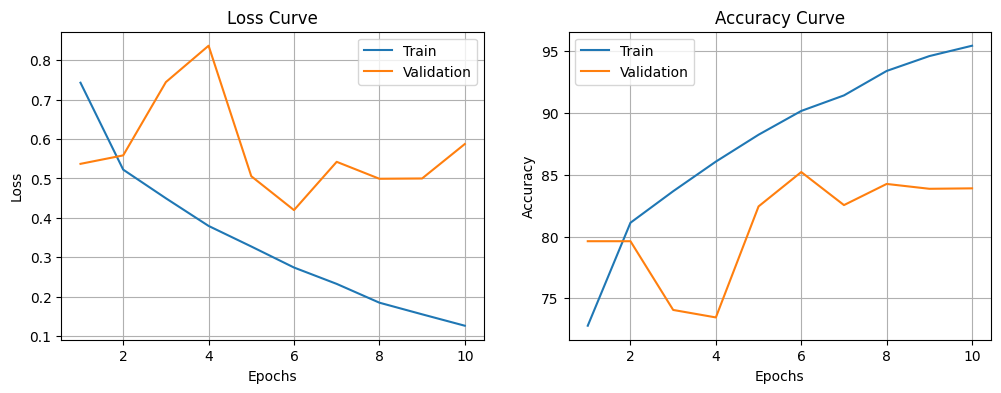

In [135]:
plt.style.use('default')


fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot([i + 1 for i in range(EPOCHS)],history['train_loss'], label = 'Train')
ax[0].plot([i + 1 for i in range(EPOCHS)],history['val_loss'], label = 'Validation')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)
ax[0].legend()

ax[1].plot([i + 1 for i in range(EPOCHS)],history['train_acc'], label = 'Train')
ax[1].plot([i + 1 for i in range(EPOCHS)],history['val_acc'], label = 'Validation')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].grid(True)
ax[1].legend()

plt.show()

### Observations

The baseline CNN demonstrates steady improvement in training accuracy; however, a noticeable gap emerges between training and validation performance as training progresses.

- Training accuracy continues to increase across epochs
- Validation accuracy saturates early
- The widening train-validation gap indicates overfitting

These results suggest that the model capacity exceeds the effective diversity of the training data, motivating the need for additional regularization and improved generalization strategies.

<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Hyperparameter Optimization with Optuna
    </h2>
</div>


The baseline CNN exhibited clear signs of overfitting, with training accuracy
continuing to improve while validation performance saturated early.
To address this, we apply hyperparameter optimization to systematically
search for better training configurations.

Instead of manually tuning parameters, we use Optuna, an automated
hyperparameter optimization framework that efficiently explores the search
space using a define-by-run approach.

### Objective Function

In [230]:
def objective(trial):

    dropout_p = trial.suggest_float("dropout_p", 0.0, 0.6)

    learning_rate = trial.suggest_float(
        "learning_rate", 1e-4, 1e-2, log=True
    )

    weight_decay = trial.suggest_float(
        "weight_decay", 1e-6, 1e-3, log=True
    )

    batch_size = trial.suggest_categorical(
        "batch_size", [16, 32, 64]
    )

    optimizer_name = trial.suggest_categorical(
        "optimizer", ["Adam", "AdamW", 'SGD']
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    model = SimpleCNN(
        input_channels=3,
        num_classes=num_classes,
        dropout_p=dropout_p
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
                                


    EPOCHS_PER_TRIAL = 10
    best_val_acc = 0.0

    for epoch in range(EPOCHS_PER_TRIAL):
        train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            DEVICE,
            optuna = 1
        )

        val_acc, _ = evaluate(
            model,
            criterion,
            val_loader,
            DEVICE,
            optuna = 1
        )

        trial.report(val_acc, epoch)

        if trial.should_prune():
            raise optuna.TrialPruned()

        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc


In [231]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)


[I 2026-01-24 19:15:55,008] A new study created in memory with name: no-name-7386c727-615c-44e7-85b5-2d9573557240


### We'll run for 25 trials

In [232]:
study.optimize(objective, n_trials = 25)

[I 2026-01-24 19:18:35,703] Trial 0 finished with value: 85.35803348770929 and parameters: {'dropout_p': 0.44042876091285843, 'learning_rate': 0.00020264785244938257, 'weight_decay': 3.955918419733958e-05, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 85.35803348770929.
[I 2026-01-24 19:21:24,080] Trial 1 finished with value: 83.11364446027788 and parameters: {'dropout_p': 0.12491570125661616, 'learning_rate': 0.0015789479546673346, 'weight_decay': 2.368658057717444e-06, 'batch_size': 16, 'optimizer': 'SGD'}. Best is trial 0 with value: 85.35803348770929.
[I 2026-01-24 19:24:22,606] Trial 2 finished with value: 86.24866405415034 and parameters: {'dropout_p': 0.15278265173590527, 'learning_rate': 0.00020673234766528106, 'weight_decay': 0.00011181011788619466, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 2 with value: 86.24866405415034.
[I 2026-01-24 19:27:07,167] Trial 3 finished with value: 85.82116138225864 and parameters: {'dropout_p': 0.333168446972355

### Best Parameter

In [323]:
best_trial = study.best_trial

print("Best Validation Accuracy:", best_trial.value)
print("Best Hyperparameters:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")


Best Validation Accuracy: 86.24866405415034
Best Hyperparameters:
  dropout_p: 0.15278265173590527
  learning_rate: 0.00020673234766528106
  weight_decay: 0.00011181011788619466
  batch_size: 16
  optimizer: Adam


### Note: Hyperparameter optimization results may vary slightly across runs due to stochastic training dynamics.


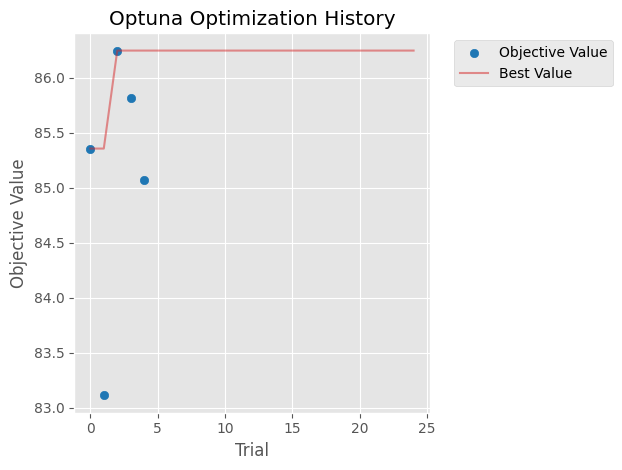

In [372]:
optuna_plt.plot_optimization_history(study)
plt.title("Optuna Optimization History")
plt.tight_layout()
plt.show()


### Optimization History
Shows the objective value per trial and the best score so far. A steady upward trend indicates effective search and convergence.
Here after 2nd trial we could not find anything better.

<Figure size 1000x2000 with 0 Axes>

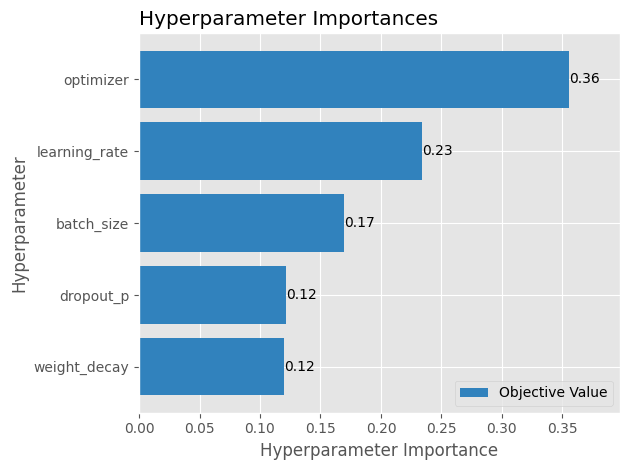

In [379]:
plt.figure(figsize=(10, 20))
optuna_plt.plot_param_importances(study)
plt.tight_layout()
plt.show()


### Hyperparameter Importance

Learning rate and optimizer has the largest impact on performance.This highlights the importance of optimizer and a suitable learning rate.

In [243]:
best_params = best_trial.params

In [244]:
FINAL_EPOCHS = 10  
BATCH_SIZE = best_params["batch_size"]
LR = best_params["learning_rate"]
WEIGHT_DECAY = best_params["weight_decay"]
DROPOUT_P = best_params["dropout_p"]
OPTIMIZER_NAME = best_params["optimizer"]

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

model = SimpleCNN(
    input_channels=3,
    num_classes=num_classes,
    dropout_p=DROPOUT_P
).to(DEVICE)


criterion = nn.CrossEntropyLoss()

if OPTIMIZER_NAME == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER_NAME == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    optimizer = optim.SGD(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

history_final = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(FINAL_EPOCHS):
    print(f"\nEpoch [{epoch+1}/{FINAL_EPOCHS}]")

    _, train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        DEVICE
    )

    val_acc, val_loss = evaluate(
        model,
        criterion,
        val_loader,
        DEVICE
    )

    history_final["train_loss"].append(train_loss)
    history_final["train_acc"].append(train_acc)
    history_final["val_loss"].append(val_loss)
    history_final["val_acc"].append(val_acc)



Epoch [1/10]
	STEP [140/702] Loss: 1.1351 | Accuracy: 60.98%
	STEP [280/702] Loss: 0.8560 | Accuracy: 65.00%
	STEP [420/702] Loss: 0.7227 | Accuracy: 67.99%
	STEP [560/702] Loss: 0.6776 | Accuracy: 69.89%
	STEP [700/702] Loss: 0.6796 | Accuracy: 71.10%
	STEP [702/702] Loss: 0.0127 | Accuracy: 71.11%
	Validation Accuracy: 73.21%

Epoch [2/10]
	STEP [140/702] Loss: 0.5913 | Accuracy: 79.24%
	STEP [280/702] Loss: 0.5992 | Accuracy: 79.31%
	STEP [420/702] Loss: 0.5708 | Accuracy: 79.48%
	STEP [560/702] Loss: 0.5665 | Accuracy: 79.63%
	STEP [700/702] Loss: 0.5249 | Accuracy: 79.95%
	STEP [702/702] Loss: 0.0060 | Accuracy: 79.95%
	Validation Accuracy: 80.48%

Epoch [3/10]
	STEP [140/702] Loss: 0.4741 | Accuracy: 83.57%
	STEP [280/702] Loss: 0.4643 | Accuracy: 83.33%
	STEP [420/702] Loss: 0.4782 | Accuracy: 83.29%
	STEP [560/702] Loss: 0.5125 | Accuracy: 83.01%
	STEP [700/702] Loss: 0.4836 | Accuracy: 83.05%
	STEP [702/702] Loss: 0.0079 | Accuracy: 83.05%
	Validation Accuracy: 83.22%

Epoch 

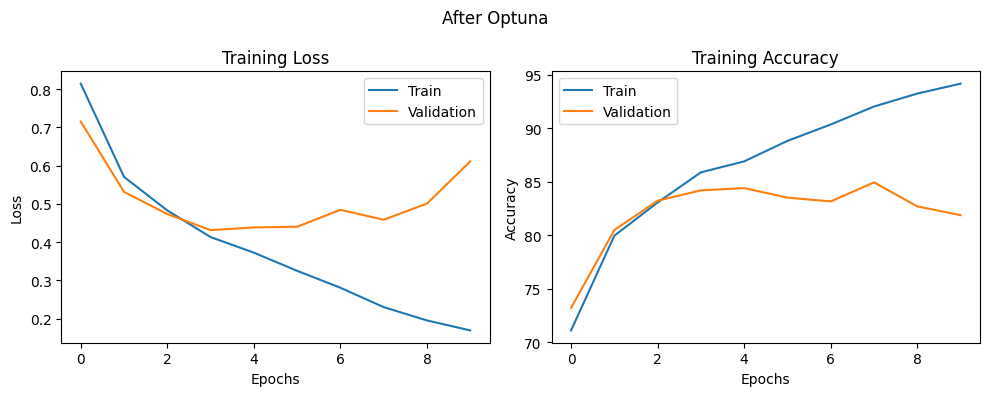

In [246]:
plt.figure(figsize=(10, 4))
plt.suptitle('After Optuna')

plt.subplot(1, 2, 1)
plt.plot(history_final["train_loss"], label="Train")
plt.plot(history_final["val_loss"], label="Validation")
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_final["train_acc"], label="Train")
plt.plot(history_final["val_acc"], label="Validation")
plt.title("Training Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Observations

Optuna uses probabilistic sampling and pruning to efficiently explore the
hyperparameter space, but the selected configuration is not guaranteed to be
globally optimal.

In this case, the scratch model reached **~95% training accuracy and ~83%
validation accuracy after 10 epochs**, indicating overfitting. With Optuna-tuned
parameters, the model achieved **~84% validation accuracy within the first
5 epochs** while keeping training accuracy lower, reflecting improved early
generalization. However, extending training led to increased training accuracy
without validation improvement.

This suggests that Optuna improved early training behavior, but was insufficient
to fully address overfitting for the CNN trained from scratch.


This indicates that the primary limitation also lies in data diversity rather than
parameter selection, motivating the introduction of data augmentation in the
next stage.

<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Data Augmentation
    </h2>
</div>


The results from hyperparameter optimization indicate that overfitting persists
despite improved training stability. This suggests that the primary limitation
is not model configuration, but insufficient data diversity.

To address this, we introduce data augmentation to increase the effective
variety of training samples and encourage the model to learn more robust,
generalizable features.

Data augmentation artificially increases the diversity of the training data by
applying random transformations to input images during training. Unlike simply
adding more data, augmentation exposes the model to multiple variations of the
same image across epochs.

Key benefits include:

- Reduced overfitting

- Improved robustness to spatial and color variations

- Better generalization to unseen data

In [247]:
train_transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(
        size=150, scale=(0.8, 1.0)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

In [248]:
train_dataset_full_aug = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transform_aug
)

val_dataset_full = datasets.ImageFolder(
    root=DATA_DIR,
    transform=val_transform
)


In [249]:
train_idx = train_dataset.indices
val_idx = val_dataset.indices

In [250]:
train_dataset_aug = torch.utils.data.Subset(
    train_dataset_full_aug, train_idx
)

val_dataset_aug = torch.utils.data.Subset(
    val_dataset_full, val_idx
)


### Experimental Setup

To isolate the effect of data augmentation:

- The CNN architecture remains unchanged

- Hyperparameters obtained from Optuna are reused

- The train-validation split remains fixed

- Only the training dataset is augmented

This ensures that any observed improvement can be attributed directly to
augmentation rather than other factors.

### Augmentation Policy

Augmentation is applied only to the training set, while validation and test
sets remain unchanged to preserve a fair evaluation.

The following transformations are used:

- Random resized cropping to simulate scale variation

- Horizontal flipping to handle viewpoint changes

- Small random rotations to improve orientation invariance

- Color jittering to increase robustness to lighting changes

All transformations are applied on-the-fly, meaning the dataset size
remains unchanged while visual diversity increases across epochs.

In [251]:
def show_augmented_samples(dataset, class_names, n=5):
    fig, axes = plt.subplots(len(class_names), n, figsize=(15, 10), facecolor = 'lightgrey')
    
    for class_idx, class_name in enumerate(class_names):
        idxs = [
            i for i, (_, label) in enumerate(dataset)
            if label == class_idx
        ][:n]

        for i, idx in enumerate(idxs):
            img, _ = dataset[idx]
            axes[class_idx, i].imshow(img.permute(1, 2, 0))
            axes[class_idx, i].axis("off")
            if i == 0:
                axes[class_idx, i].set_ylabel(class_name)

    plt.suptitle("Augmented Training Samples", fontsize=16)
    plt.tight_layout()
    plt.show()


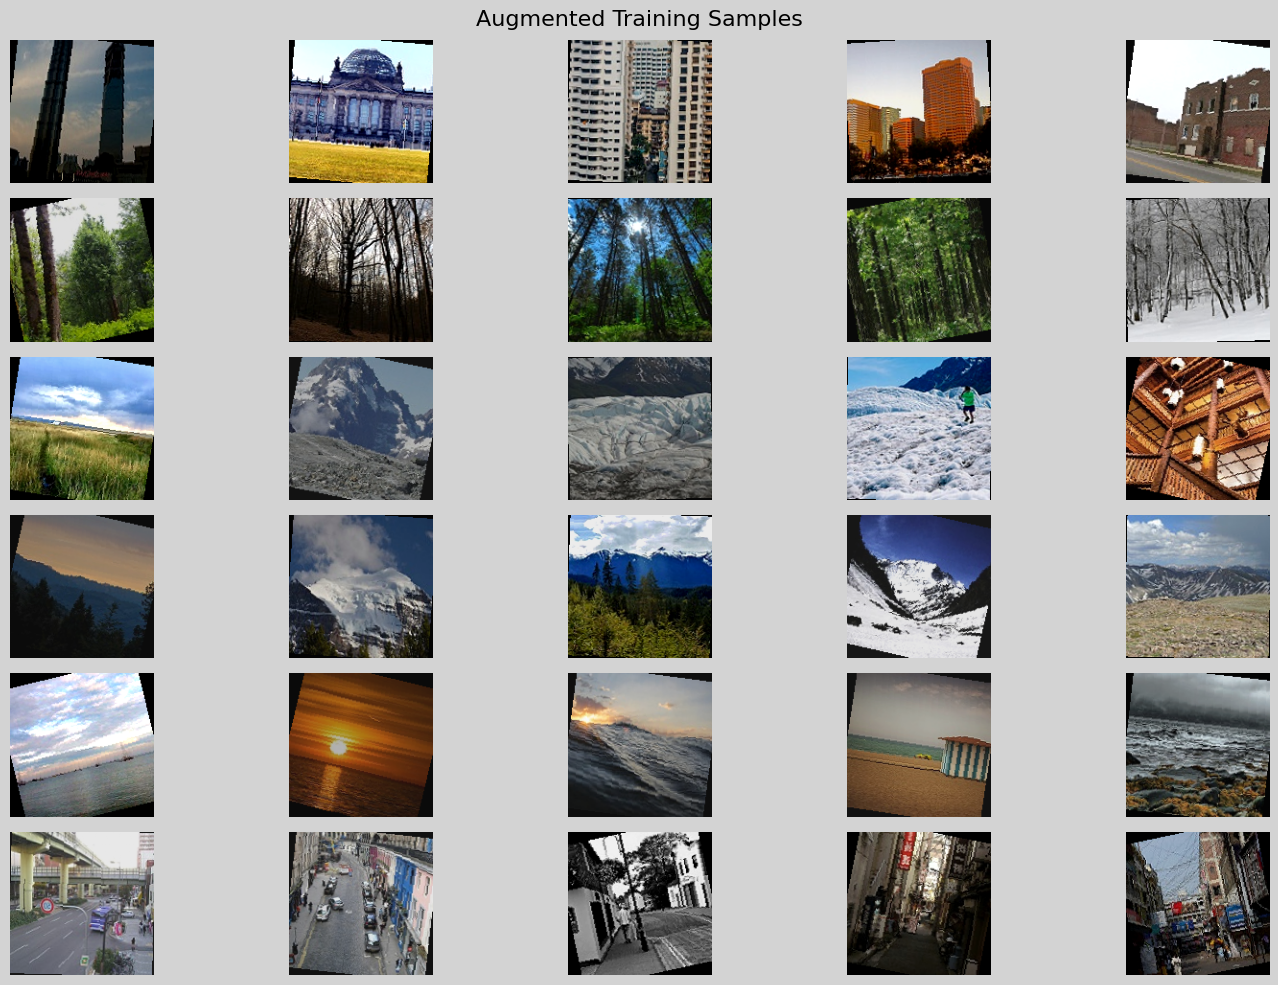

In [252]:
show_augmented_samples(train_dataset_aug, class_names)


In [253]:
def visualize_aug_per_image(dataset, idx = 0):

    fig, ax = plt.subplots(2,4, figsize = (12, 6), facecolor = 'lightgrey')
    ax = ax.flatten()

    for i in range(8):
        img, label = dataset[idx]

        ax[i].imshow(img.permute(1,2,0))
        ax[i].set_title(f"Version {i + 1}")
        ax[i].axis('off')

    plt.suptitle(f'Same class (index {idx}), different augmentations')
    plt.tight_layout()
    plt.show()

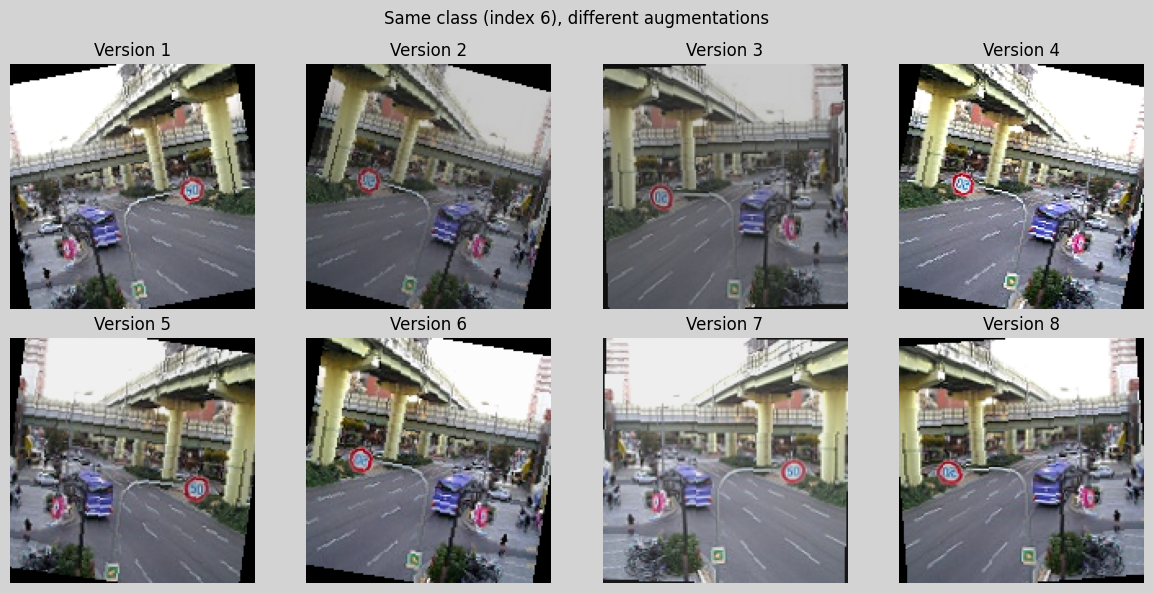

In [254]:
visualize_aug_per_image(train_dataset_aug, idx = 6)

The augmented samples demonstrate meaningful variations in scale, orientation,
and color while preserving semantic content, helping the model learn
augmentation-invariant features.


In [255]:
BATCH_SIZE = best_params["batch_size"]

train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_aug = DataLoader(
    val_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

model_aug = SimpleCNN(
    input_channels=3,
    num_classes=num_classes,
    dropout_p=best_params["dropout_p"]
).to(DEVICE)


criterion = nn.CrossEntropyLoss()

optimizer = (
    torch.optim.AdamW(
        model_aug.parameters(),
        lr=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"]
    )
    if best_params["optimizer"] == "AdamW"
    else torch.optim.Adam(
        model_aug.parameters(),
        lr=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"]
    )
)


EPOCHS = 10

history_aug = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    _, train_loss, train_acc = train_one_epoch(
        model_aug,
        train_loader_aug,
        optimizer,
        criterion,
        DEVICE,
        data_aug = 1
    )

    val_acc, val_loss = evaluate(
        model_aug,
        criterion,
        val_loader_aug,
        DEVICE
    )

    history_aug["train_loss"].append(train_loss)
    history_aug["train_acc"].append(train_acc)
    history_aug["val_loss"].append(val_loss)
    history_aug["val_acc"].append(val_acc)



Epoch [1/10]
	Training Accuracy: 65.33%
	Validation Accuracy: 75.92%

Epoch [2/10]
	Training Accuracy: 74.60%
	Validation Accuracy: 81.05%

Epoch [3/10]
	Training Accuracy: 76.84%
	Validation Accuracy: 76.45%

Epoch [4/10]
	Training Accuracy: 78.44%
	Validation Accuracy: 84.47%

Epoch [5/10]
	Training Accuracy: 79.60%
	Validation Accuracy: 81.69%

Epoch [6/10]
	Training Accuracy: 82.03%
	Validation Accuracy: 85.18%

Epoch [7/10]
	Training Accuracy: 81.45%
	Validation Accuracy: 83.79%

Epoch [8/10]
	Training Accuracy: 82.80%
	Validation Accuracy: 86.36%

Epoch [9/10]
	Training Accuracy: 83.55%
	Validation Accuracy: 87.99%

Epoch [10/10]
	Training Accuracy: 84.31%
	Validation Accuracy: 87.28%


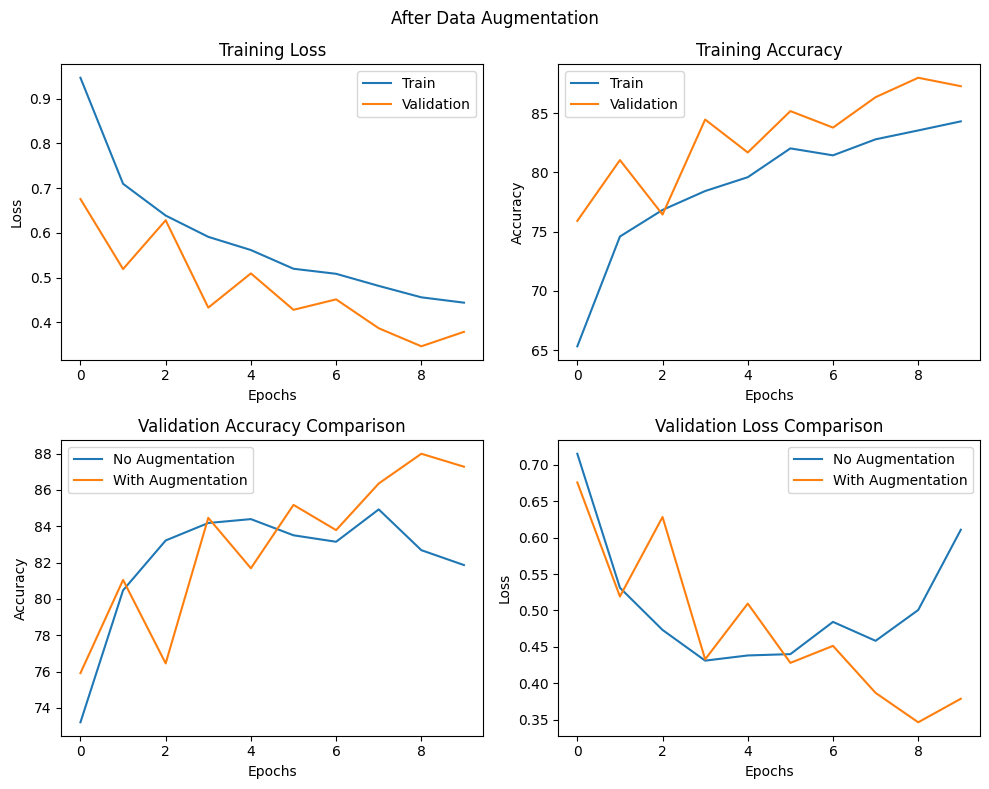

In [256]:
plt.figure(figsize=(10, 8))
plt.suptitle('After Data Augmentation')

plt.subplot(2, 2, 1)
plt.plot(history_aug["train_loss"], label="Train")
plt.plot(history_aug["val_loss"], label="Validation")
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_aug["train_acc"], label="Train")
plt.plot(history_aug["val_acc"], label="Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history_final["val_acc"], label="No Augmentation")
plt.plot(history_aug["val_acc"], label="With Augmentation")
plt.title("Validation Accuracy Comparison")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_final["val_loss"], label="No Augmentation")
plt.plot(history_aug["val_loss"], label="With Augmentation")
plt.title("Validation Loss Comparison")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Observations

After introducing data augmentation:

- The gap between training and validation accuracy is significantly reduced (Slightly underfitting)

- Validation accuracy improves consistently across epochs

- The model demonstrates more stable convergence behavior

- Performing better on unseen data

- These results confirm that data diversity was one of the key bottleneck in training
the CNN from scratch.

<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Transfer Learning with Data Augmentation
    </h2>
</div>


While data augmentation significantly reduced overfitting for the CNN trained
from scratch, the model still lacks strong high-level visual representations.

In this section, we apply **transfer learning** using a pretrained backbone
trained on ImageNet, combined with **data augmentation**, to further improve
generalization performance.


In [257]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform_tl = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_transform_tl = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [258]:
train_dataset_tl_full = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transform_tl
)

val_dataset_tl_full = datasets.ImageFolder(
    root=DATA_DIR,
    transform=val_transform_tl
)

train_dataset_tl = torch.utils.data.Subset(
    train_dataset_tl_full, train_idx
)

val_dataset_tl = torch.utils.data.Subset(
    val_dataset_tl_full, val_idx
)


In [259]:
BATCH_SIZE_TL = 32 

train_loader_tl = DataLoader(
    train_dataset_tl,
    batch_size=BATCH_SIZE_TL,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_tl = DataLoader(
    val_dataset_tl,
    batch_size=BATCH_SIZE_TL,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)




<img src='https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png' style="display: block; margin-left: auto; margin-right: auto; width: 50%;">


To better understand the impact of fine-tuning depth in transfer learning, we
evaluate three different strategies using the pretrained ResNet18 model.
Each strategy progressively increases the number of trainable parameters while
keeping all other factors constant.

1. Frozen Backbone (Feature Extraction)
2. Partial Fine-Tuning (Unfreeze Final Convolutional Block)
3. Full Fine-Tuning (Unfreeze All Layers) 

<div style="
    background: #f8fafc;
    padding: 12px 18px;
    border-radius: 10px;
    margin: 24px auto;
    border-left: 4px solid #6366f1;
    max-width: 720px;
    text-align: center;
">
    <h3 style="
        margin: 0;
        font-size: 20px;
        font-weight: 600;
        color: #1e293b;
    ">
        1. Frozen Backbone (Feature Extraction)
    </h3>
</div>


All pretrained layers are frozen, and only the final classification layer is
trained. This approach relies entirely on generic ImageNet features.

In [293]:
model_tl = models.resnet18(pretrained=True)

for param in model_tl.parameters():
    param.requires_grad = False

num_features = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_features, num_classes)

model_tl = model_tl.to(DEVICE)


In [261]:
for name, param in model_tl.named_parameters():
    if param.requires_grad:
        print(name)


fc.weight
fc.bias


In [262]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model_tl.fc.parameters(),  
    lr=1e-3
)

EPOCHS_FROZEN = 10

history_tl_frozen = {
    "train_acc": [],
    "val_acc": []
}

for epoch in range(EPOCHS_FROZEN):
    print(f"\nEpoch [{epoch+1}/{EPOCHS_FROZEN}] (Frozen)")

    _, _, train_acc = train_one_epoch(
        model_tl,
        train_loader_tl,
        optimizer,
        criterion,
        DEVICE,
        data_aug = 1
    )

    val_acc, _ = evaluate(
        model_tl,
        criterion,
        val_loader_tl,
        DEVICE,
    )

    history_tl_frozen["val_acc"].append(val_acc)
    history_tl_frozen['train_acc'].append(train_acc)



Epoch [1/10] (Frozen)
	Training Accuracy: 80.01%
	Validation Accuracy: 89.74%

Epoch [2/10] (Frozen)
	Training Accuracy: 86.58%
	Validation Accuracy: 89.13%

Epoch [3/10] (Frozen)
	Training Accuracy: 87.02%
	Validation Accuracy: 90.63%

Epoch [4/10] (Frozen)
	Training Accuracy: 87.65%
	Validation Accuracy: 89.70%

Epoch [5/10] (Frozen)
	Training Accuracy: 88.26%
	Validation Accuracy: 90.56%

Epoch [6/10] (Frozen)
	Training Accuracy: 87.82%
	Validation Accuracy: 89.78%

Epoch [7/10] (Frozen)
	Training Accuracy: 87.94%
	Validation Accuracy: 89.67%

Epoch [8/10] (Frozen)
	Training Accuracy: 88.30%
	Validation Accuracy: 89.56%

Epoch [9/10] (Frozen)
	Training Accuracy: 88.62%
	Validation Accuracy: 90.67%

Epoch [10/10] (Frozen)
	Training Accuracy: 88.33%
	Validation Accuracy: 90.49%


<div style="
    background: #f8fafc;
    padding: 12px 18px;
    border-radius: 10px;
    margin: 24px auto;
    border-left: 4px solid #6366f1;
    max-width: 720px;
    text-align: center;
">
    <h3 style="
        margin: 0;
        font-size: 20px;
        font-weight: 600;
        color: #1e293b;
    ">
        2. Partial Fine-Tuning (Unfreeze Final Convolutional Block)
    </h3>
</div>


Only the final convolutional block (layer4) and the classifier head are
unfrozen. This allows the model to adapt high-level semantic features while
preserving robust low-level representations.

In [263]:
model_tl_3 = models.resnet18(pretrained=True)

for param in model_tl_3.parameters():
    param.requires_grad = False

for param in model_tl_3.layer4.parameters():
    param.requires_grad = True

num_features = model_tl_3.fc.in_features
model_tl_3.fc = nn.Linear(num_features, num_classes)

    
for param in model_tl_3.fc.parameters():
    param.requires_grad = True

model_tl_3 = model_tl_3.to(DEVICE)

In [264]:
for name, param in model_tl_3.named_parameters():
    if param.requires_grad:
        print(name)


layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [265]:
optimizer = torch.optim.Adam(
    [
        {"params": model_tl_3.layer4.parameters(), "lr": 1e-4},
        {"params": model_tl_3.fc.parameters(), "lr": 1e-3},
    ]
)

history_tl_frozen3 = {
    "train_acc": [],
    "val_acc": []
}


EPOCHS_FINETUNE = 5

for epoch in range(EPOCHS_FINETUNE):
    print(f"\nEpoch [{epoch+1}/{EPOCHS_FINETUNE}] (Frozen till layer 3)")
    _,_, train_acc = train_one_epoch(
        model_tl_3,
        train_loader_tl,
        optimizer,
        criterion,
        DEVICE,
        data_aug = 1
    )

    val_acc, _ = evaluate(
        model_tl_3,
        criterion,
        val_loader_tl,
        DEVICE
    )

    history_tl_frozen3["val_acc"].append(val_acc)
    history_tl_frozen3['train_acc'].append(train_acc)




Epoch [1/5] (Frozen till layer 3)
	Training Accuracy: 87.84%
	Validation Accuracy: 89.88%

Epoch [2/5] (Frozen till layer 3)
	Training Accuracy: 91.90%
	Validation Accuracy: 92.63%

Epoch [3/5] (Frozen till layer 3)
	Training Accuracy: 93.28%
	Validation Accuracy: 92.77%

Epoch [4/5] (Frozen till layer 3)
	Training Accuracy: 94.34%
	Validation Accuracy: 93.69%

Epoch [5/5] (Frozen till layer 3)
	Training Accuracy: 95.53%
	Validation Accuracy: 93.59%


<div style="
    background: #f8fafc;
    padding: 12px 18px;
    border-radius: 10px;
    margin: 24px auto;
    border-left: 4px solid #6366f1;
    max-width: 720px;
    text-align: center;
">
    <h3 style="
        margin: 0;
        font-size: 20px;
        font-weight: 600;
        color: #1e293b;
    ">
        3. Full Fine-Tuning (Unfreeze All Layers)
    </h3>
</div>



All layers of the pretrained network are unfrozen and updated during training,
allowing full adaptation to the target dataset.

In [266]:
model_tl_all = models.resnet18(pretrained=True)

num_features = model_tl_all.fc.in_features
model_tl_all.fc = nn.Linear(num_features, num_classes)



model_tl_all = model_tl_all.to(DEVICE)


In [267]:
for name, param in model_tl_all.named_parameters():
    if param.requires_grad:
        print(name)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [268]:
optimizer = torch.optim.Adam(
    model_tl_all.parameters(),
    lr=1e-4
)

EPOCHS_FINETUNE = 5

history_tl_finetuned = {
    "train_acc": [],
    "val_acc": []
}

for epoch in range(EPOCHS_FINETUNE):
    print(f"\nEpoch [{epoch+1}/{EPOCHS_FINETUNE}] (Fine-tuning)")

    _,_, train_acc = train_one_epoch(
        model_tl_all,
        train_loader_tl,
        optimizer,
        criterion,
        DEVICE,
        data_aug = 1
    )

    val_acc, _ = evaluate(
        model_tl_all,
        criterion,
        val_loader_tl,
        DEVICE
    )

    history_tl_finetuned["val_acc"].append(val_acc)
    history_tl_finetuned["train_acc"].append(train_acc)



Epoch [1/5] (Fine-tuning)
	Training Accuracy: 88.71%
	Validation Accuracy: 93.12%

Epoch [2/5] (Fine-tuning)
	Training Accuracy: 92.36%
	Validation Accuracy: 93.52%

Epoch [3/5] (Fine-tuning)
	Training Accuracy: 93.80%
	Validation Accuracy: 93.55%

Epoch [4/5] (Fine-tuning)
	Training Accuracy: 94.62%
	Validation Accuracy: 92.13%

Epoch [5/5] (Fine-tuning)
	Training Accuracy: 95.60%
	Validation Accuracy: 92.48%


<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Final Model Selection
    </h2>
</div>


Both partial and full fine-tuning achieved comparable validation accuracy within
a small number of epochs. The partial fine-tuned model performs slightly better therefore selected as the
final configuration

In [291]:
MODEL_PATH = "final_resnet18_layer4.pth"

torch.save(model_tl.state_dict(), MODEL_PATH)

print("Model saved successfully!")


Model saved successfully!


In [269]:
histories = {
    "CNN Baseline": history,
    "CNN + Optuna": history_final,
    "CNN + Optuna + Augmentation": history_aug,
    "TL Unfreeze classifier": history_tl_frozen,
    "TL Unfreeze Layer4": history_tl_frozen3,
    "TL Unfreeze All": history_tl_finetuned
}


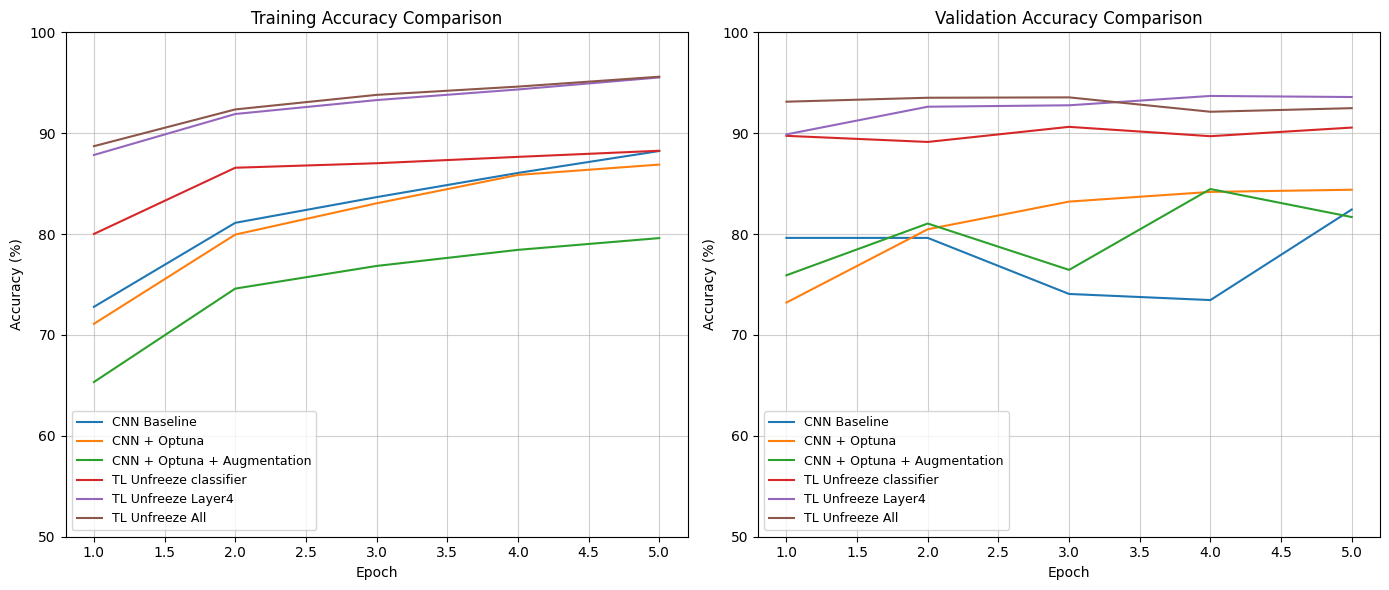

In [270]:

plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)

for name, hist in histories.items():
    epochs = range(1, len(hist["train_acc"][:5]) + 1)
    plt.plot(epochs, hist["train_acc"][:5], label=name)

plt.title("Training Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(50, 100)
plt.legend(fontsize=9, loc= 'best')
plt.grid(True, alpha=0.6)


plt.subplot(1, 2, 2)

for name, hist in histories.items():
    epochs = range(1, len(hist["val_acc"][:5]) + 1)
    plt.plot(epochs, hist["val_acc"][:5], label=name)

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(50, 100)
plt.legend(fontsize=9, loc = 'best')
plt.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()


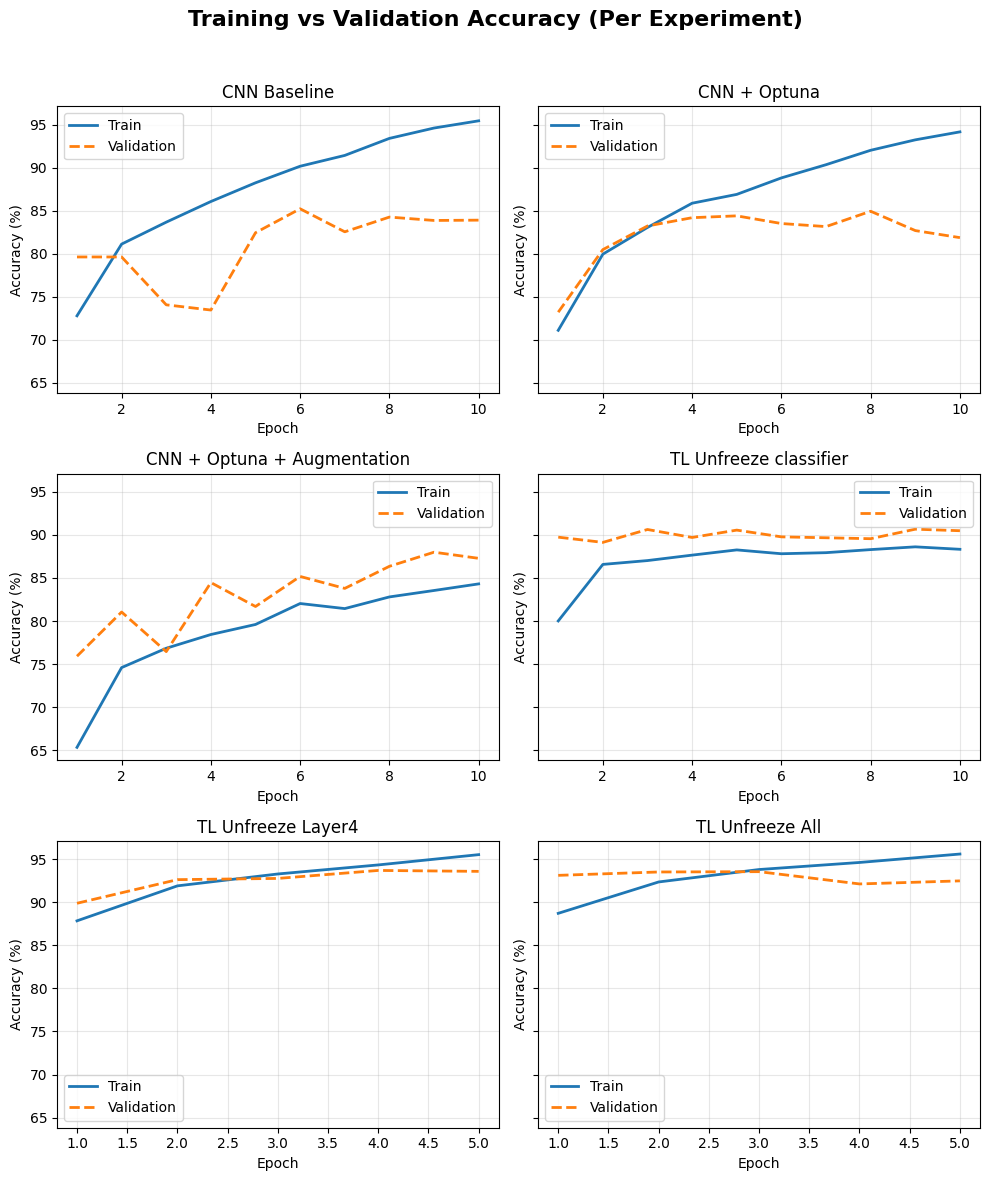

In [271]:
num_plots = len(histories)
cols = 2
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(
    rows, cols,
    figsize=(10, 4 * rows),
    sharex=False,
    sharey=True
)

axes = axes.flatten()

for idx, (name, hist) in enumerate(histories.items()):
    ax = axes[idx]
    epochs = range(1, len(hist["train_acc"]) + 1)

    ax.plot(
        epochs,
        hist["train_acc"],
        label="Train",
        linewidth=2
    )
    ax.plot(
        epochs,
        hist["val_acc"],
        label="Validation",
        linestyle="--",
        linewidth=2
    )

    ax.set_title(name)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.grid(True, alpha=0.3)
    ax.legend()

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(
    "Training vs Validation Accuracy (Per Experiment)",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<div style="
    background: #f1f5f9;
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    border-left: 6px solid #2563eb;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #0f172a;
    ">
        Final Evaluation on Test Set
    </h2>
</div>


In [272]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=IMAGENET_MEAN,
        std=IMAGENET_STD
    )
])

test_dataset = datasets.ImageFolder(
    root="/kaggle/input/intel-image-classification/seg_test/seg_test",
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [282]:
test_acc, test_loss = evaluate(
    model_tl_3,
    criterion,
    test_loader,
    DEVICE,
    optuna = 1
)

print(f"Final Test Accuracy: {test_acc:.2f}%")


Final Test Accuracy: 93.67%


In [283]:
def get_test_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds


In [284]:
y_true, y_pred = get_test_predictions(
    model_tl_3,
    test_loader,
    DEVICE
)


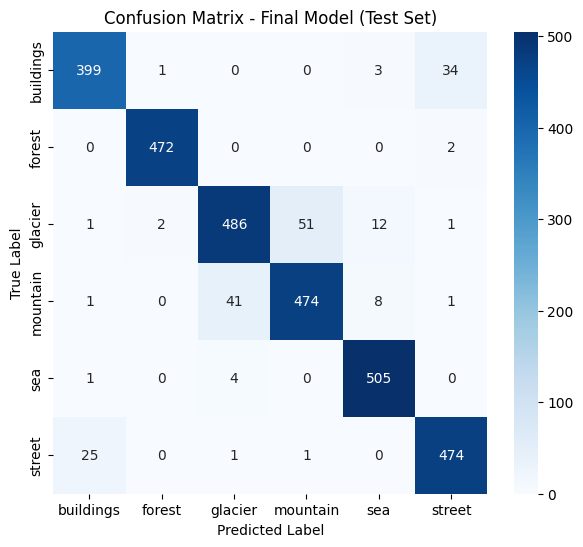

In [285]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_dataset.classes,
    yticklabels=test_dataset.classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Final Model (Test Set)")
plt.show()


<div style="
    background: #f8fafc;
    padding: 12px 18px;
    border-radius: 10px;
    margin: 24px auto;
    border-left: 4px solid #6366f1;
    max-width: 720px;
    text-align: center;
">
    <h3 style="
        margin: 0;
        font-size: 20px;
        font-weight: 600;
        color: #1e293b;
    ">
        Misclassification Analysis
    </h3>
</div>


The confusion matrix reveals that most misclassifications occur between visually similar scene categories. 
This behavior is expected for natural scene datasets where semantic boundaries are often ambiguous.

### Common Misclassification Patterns

- **Buildings - Street**
  Urban environments often contain overlapping visual cues such as roads, facades, and vehicles.

- **Mountain - Glacier**
  Snow-covered mountains share strong textural and color similarities with glacier scenes.

- **Sea - Glacier**
  Both classes may include large uniform regions with cool color tones, leading to occasional confusion.

### Interpretation

These errors are largely due to **inherent dataset ambiguity** rather than model failure.
In many cases, even human annotators may find such images challenging to classify consistently.

Overall, the model demonstrates strong generalization, with misclassifications concentrated in semantically overlapping classes.


In [286]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=test_dataset.classes
    )
)


              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       437
      forest       0.99      1.00      0.99       474
     glacier       0.91      0.88      0.90       553
    mountain       0.90      0.90      0.90       525
         sea       0.96      0.99      0.97       510
      street       0.93      0.95      0.94       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



### Results

The final model achieves strong classification performance on the test set, managed to get achieved ~90+ f1 score per-class
demonstrating effective generalization to unseen images.

Performance is analyzed using:

- Overall classification accuracy

- Confusion matrix

- Per-class precision and recall


In [289]:
def show_test_predictions(model, dataset, loader, class_names, n=6):
    model.eval()
    shown = 0
    plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):

                img = denormalize(images[i].cpu())
                img = img.permute(1, 2, 0)

                true = class_names[labels[i]]
                pred = class_names[preds[i]]

                plt.subplot(2, n // 2, shown + 1)
                plt.imshow(img)
                plt.title(f"True: {true}\nPredicted: {pred}")
                plt.axis("off")

                shown += 1
                if shown == n:
                    plt.tight_layout()
                    plt.show()
                    return

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.clone()
    img = img * IMAGENET_STD[:, None, None] + IMAGENET_MEAN[:, None, None]
    return img



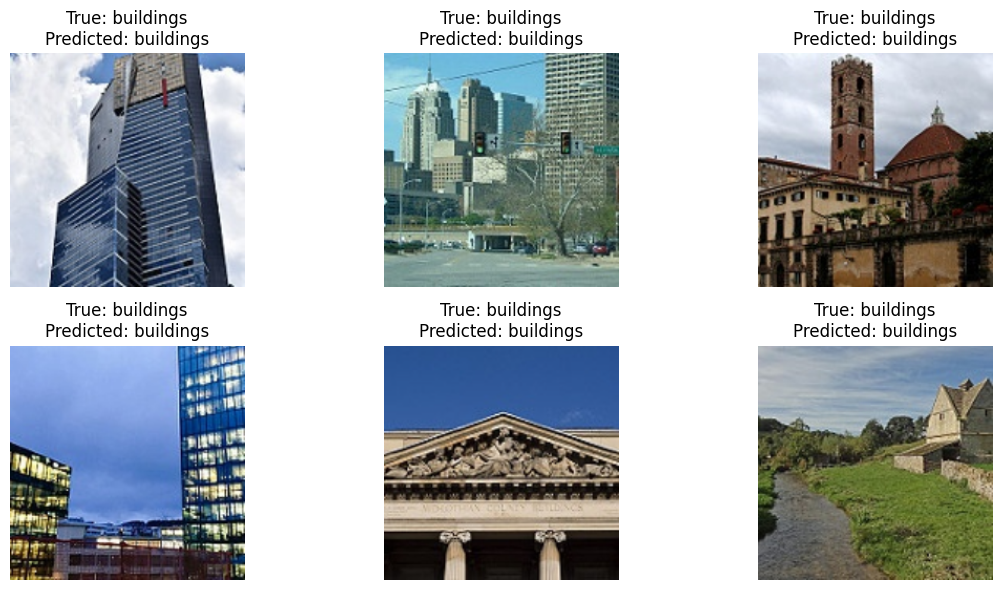

In [290]:
show_test_predictions(model_tl_3, test_dataset, test_loader, class_names)

<div style="
    background: linear-gradient(90deg, #0f172a, #1e293b);
    padding: 16px 22px;
    border-radius: 12px;
    margin: 32px auto;
    max-width: 900px;
    text-align: center;
">
    <h2 style="
        margin: 0;
        font-size: 24px;
        font-weight: 700;
        color: #f8fafc;
    ">
        Final Remarks
    </h2>
</div>


- The final model achieves strong performance on the unseen test set
- Errors are concentrated in visually overlapping scene categories
- Misclassifications reflect real-world ambiguity rather than systematic model bias
- The results validate the effectiveness of transfer learning, regularization, and hyperparameter optimization
